In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

# HVAC Maintenance Case Study

## Import Data

In [21]:
import nestor.keyword as kex
data_dir = Path('../..')/'data'/'hvac_data'
df = pd.read_csv(data_dir/'hvac_data.csv')
# really important things we know, a priori
special_replace={'action taken': '',
                 ' -': '; ',
                 '- ': '; ',
                 'too hot': 'too_hot',
                 'to hot': 'too_hot',
                 'too cold': 'too_cold',
                 'to cold': 'too_cold'}

nlp_select = kex.NLPSelect(columns = ['DESCRIPTION', 'LONG_DESCRIPTION'], special_replace=special_replace)
raw_text = nlp_select.transform(df)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29,30,40,106,172,196,217,227) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Build Vocab

In [22]:

tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)
print(tex.vocab_)

['room' 'poc' 'stat' ..., 'llines' 'pictures' 'logged']


In [23]:
vocab_fname = data_dir/'vocab.csv'
# vocab_fname = data_dir/'mine_vocab_app.csv'

# vocab = tex.annotation_assistant(filename = vocab_fname)
vocab = kex.generate_vocabulary_df(tex, init = vocab_fname)

intialized successfully!


### Extract Keywords

In [24]:
tag_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)
tags_read = kex._get_readable_tag_df(tag_df)

intialized successfully!


In [25]:
tags_read.head(5)

,I,NA,P,S,U,X
0,,"pm, order, site, aml, charge",,complete,,
1,time,"pm, cover, order, aml, charge, charged",,need,,
2,"point_of_contact, thermostat",ed,,"replace, adjust, reset, repair",freeze,
3,"point_of_contact, thermostat",ed,,"adjust, reset, repair, restart",freeze,
4,thermostat,,,"adjust, reset, repair",freeze,


In [26]:

# vocab = pd.read_csv(data_dir/'app_vocab_mike.csv', index_col=0)
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  5000
total tags:  86


,NE,alias,notes,score
NE,,,,
,1,1,1,4650
I,1,45,5,204
P,1,7,2,26
S,1,16,3,70
U,1,14,8,26
X,1,3,2,6


Tag completeness: 0.60 +/- 0.19
Complete Docs: 254, or 1.50%
Empty Docs: 126, or 0.74%
Docs have at most 20 tokens (90th percentile)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


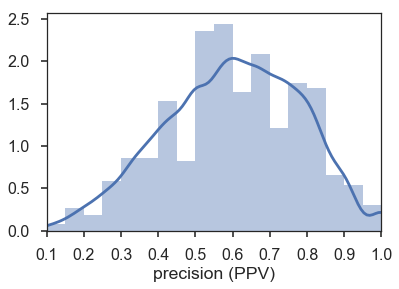

In [27]:
# tag-completeness of work-orders?
tag_pct, tag_comp, tag_empt = kex.get_tag_completeness(tag_df)

nbins = int(np.percentile(tag_df.sum(axis=1), 90))
print(f'Docs have at most {nbins} tokens (90th percentile)')

with sns.axes_style('ticks') as style,\
sns.plotting_context('poster') as context:
    sns.distplot(tag_pct.dropna(), bins=nbins, kde_kws={'cut':0})
    plt.xlim(0.1, 1.0)
    plt.xlabel('precision (PPV)')


## Measuring Machine Performance

Text(0.5,0.98,'Tag Occurence')

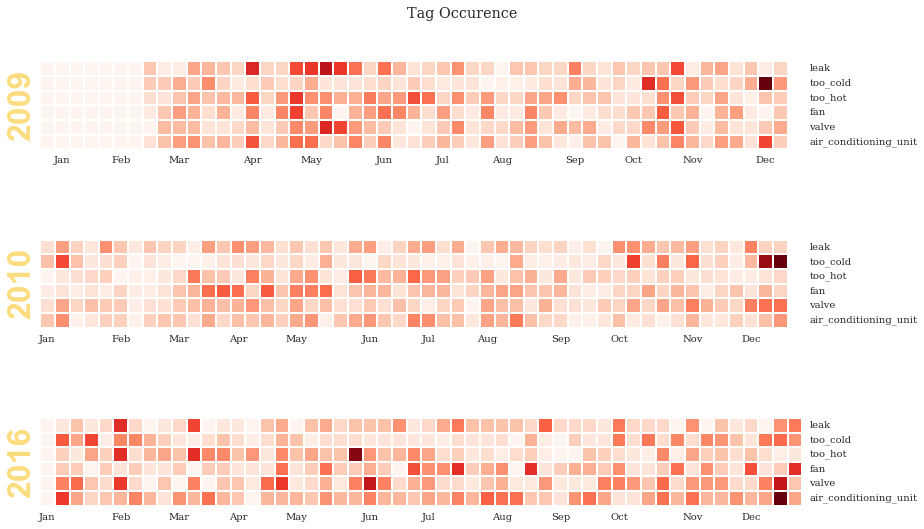

In [28]:
import nestor.tagplots as tagplt
samp = ['air_conditioning_unit','fan', 'valve', 'leak', 'too_hot', 'too_cold']
cond = (tag_df.P.alarm==1)
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

idx_col = pd.DatetimeIndex(df.REPORTDATE)
sample_tag = sample_tag.set_index(idx_col[:])
sample_tag = sample_tag[ sample_tag.index.year.isin([2009, 2010, 2016])]


tagplt.tagcalendarplot(sample_tag,
                  how='sum', fig_kws={'figsize':(13,8)});
plt.suptitle('Tag Occurence')

### Monthly "too-hot" and "too-cold" requests, over time

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
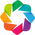

In [16]:
import holoviews as hv
import geoviews as gv
hv.extension('bokeh')

In [17]:
%%output size=250 

temp_curve_spec = {
    'Spread':{'plot':{'width':300, 'height':80}, 
              'style':dict(line_color=None, alpha=.4, color=hv.Cycle(['#fe420f', '#06b1c4']))},
    'Curve':{'style':dict(color=hv.Cycle(['#fe420f', '#06b1c4']), line_dash='dotted')},
    'Scatter':{'style':dict( size=5, color=hv.Cycle(['#fe420f', '#06b1c4']))}
}

samp = ['too_cold', 'too_hot']
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = sample_tag.set_index(idx_col).sort_index()
meas = sample_tag.resample('30D').sum()
roll = sample_tag.rolling('30D').sum()
mean = roll.resample('30D').mean()
err = roll.resample('30D').std()
    
temp_curves = hv.Overlay([hv.Spread((mean.index, mean.too_hot, 2*err.too_hot)),
                          hv.Spread((mean.index, mean.too_cold, 2*err.too_cold)),
                          hv.Curve((meas.index, meas.too_hot)),
                          hv.Curve((meas.index, meas.too_cold)),
                          hv.Scatter((meas.index, meas.too_hot), label='too_hot'),
                          hv.Scatter((meas.index, meas.too_cold), label='too_cold')])
temp_curves.opts(temp_curve_spec)#*hv.VLine(times[5])

:Overlay
   .Spread.I         :Spread   [x]   (y,yerror)
   .Spread.II        :Spread   [x]   (y,yerror)
   .Curve.I          :Curve   [x]   (y)
   .Curve.II         :Curve   [x]   (y)
   .Scatter.Too_hot  :Scatter   [x]   (y)
   .Scatter.Too_cold :Scatter   [x]   (y)

In [18]:
import geopandas as gpd 
nist_df = gpd.read_file(str(data_dir/'nist_map.geojson')).set_index('bldg', drop=False)
nist_df.index = nist_df.index.astype(str)
samp = ['too_cold', 'too_hot']
sample_tag = tag_df.loc[:,(slice(None), samp)]
sample_tag.columns = sample_tag.columns.droplevel(0)

bldg_col = df.LOCATION.str.split('-').str[0].astype('category')
sample_tag = pd.concat([sample_tag, bldg_col], axis=1)
sample_tag = sample_tag.set_index(idx_col).sort_index()
sample_tag.rename({'LOCATION':'bldg'}, axis='columns', inplace=True)

times = sample_tag.resample('30D').sum().index
# pd.concat([sample_tag.loc[times[0]:times[1]].groupby('bldg').sum(), nist_df], axis=1).dropna()

def get_bldg_temp(n):
    data = gpd.GeoDataFrame(pd.concat([sample_tag.loc[times[n]:times[n+1]].groupby('bldg').sum(), 
                      nist_df], 
                     axis=1).dropna())
    data['Temperature Index'] = np.tanh((data['too_cold'].sum()+data['too_hot'].sum())/20)*\
    (data['too_cold'] - data['too_hot'])
    return data
# np.tanh((data['too_cold'].sum()+data['too_hot'].sum())/20)*\
get_bldg_temp(1).head()


,too_hot,too_cold,bldg,geometry,Temperature Index
bldg,,,,,
101,2,3,101.0,"POLYGON ((-77.2163987159729 39.13512015465694,...",0.995524
202,0,1,202.0,POLYGON ((-77.22025036811827 39.13047428646352...,0.995524
203,0,0,203.0,POLYGON ((-77.22077608108521 39.13020796677279...,0.000000
205,0,0,205.0,"POLYGON ((-77.21850156784058 39.1223198699503,...",0.000000
215,1,0,215.0,"POLYGON ((-77.21671521663666 39.1316623096919,...",-0.995524


In [25]:
get_bldg_temp(0).bldg.astype('str')
# text = hv.Text(get_bldg_temp(0).geometry.centroid.x-.0002,
#                get_bldg_temp(0).geometry.centroid.y-.00015,
#                get_bldg_temp(0).index.tolist())

# gv.Polygons(get_bldg_temp(0), 
#                          vdims=['Temperature Index', 'bldg', 'too_hot', 'too_cold'],
#                          extents = extents)

bldg
101    101.0
202    202.0
203    203.0
205    205.0
215    215.0
216    216.0
217    217.0
218    218.0
219    219.0
220    220.0
221    221.0
222    222.0
223    223.0
224    224.0
225    225.0
226    226.0
227    227.0
230    230.0
231    231.0
233    233.0
235    235.0
236    236.0
245    245.0
301    301.0
302    302.0
303    303.0
304    304.0
318    318.0
320    320.0
411    411.0
Name: bldg, dtype: object

In [19]:
from bokeh.palettes import Viridis10, Category10_6, RdBu10
from bokeh.models.mappers import LinearColorMapper
RdBu10.reverse()
padding = dict(x=(-77.223, -77.214), y=(39.13, 39.14))
extents = (-77.223, 39.129, -77.214, 39.1385)

bldg_dict, vlines = {}, {}
for n, time in enumerate(times[:-1]):
    mapped = gv.Polygons(get_bldg_temp(n), 
                         vdims=['Temperature Index', 'bldg', 'too_hot', 'too_cold'],
                         extents = extents)
    mapped = mapped.redim.range(**padding)
    vlines[time] = hv.VLine(time).opts(style={'color':'black'})
    bldg_dict[time] = mapped
    
text = hv.Overlay([gv.Text(i.centroid.x-.0002, 
                           i.centroid.y-.00015, 
                           str(name)) for name,i in get_bldg_temp(0).geometry.iteritems()])


In [20]:
%%output size=200 filename='nist_hvac_map'
%%opts Polygons [height=350 width=300, tools=['hover'] colorbar=False ] (cmap='RdBu')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

(hv.HoloMap(bldg_dict, 'Time')*text + hv.HoloMap(vlines, 'Time')*temp_curves.opts(temp_curve_spec)).cols(1)
# hv.Bounds()

:Layout
   .HoloMap.I  :HoloMap   [Time]
      :Overlay
         .Polygons.I  :Polygons   [Longitude,Latitude]   (Temperature Index,bldg,too_hot,too_cold)
         .Text.I      :Text   [x,y]
         .Text.II     :Text   [x,y]
         .Text.III    :Text   [x,y]
         .Text.IV     :Text   [x,y]
         .Text.V      :Text   [x,y]
         .Text.VI     :Text   [x,y]
         .Text.VII    :Text   [x,y]
         .Text.VIII   :Text   [x,y]
         .Text.IX     :Text   [x,y]
         .Text.X      :Text   [x,y]
         .Text.XI     :Text   [x,y]
         .Text.XII    :Text   [x,y]
         .Text.XIII   :Text   [x,y]
         .Text.XIV    :Text   [x,y]
         .Text.XV     :Text   [x,y]
         .Text.XVI    :Text   [x,y]
         .Text.XVII   :Text   [x,y]
         .Text.XVIII  :Text   [x,y]
         .Text.XIX    :Text   [x,y]
         .Text.XX     :Text   [x,y]
         .Text.XXI    :Text   [x,y]
         .Text.XXII   :Text   [x,y]
         .Text.XXIII  :Text   [x,y]
         .Text.XXIV   :Text   [x,y]
         .Text.XXV    :Text   [x,y]
         .Text.XXVI   :Text   [x,y]
         .Text.XXVII  :Text   [x,y]
         .Text.XXVIII :Text   [x,y]
         .Text.XXIX   :Text   [x,y]
         .Text.XXX    :Text   [x,y]
   .HoloMap.II :HoloMap   [Time]
      :Overlay
         .VLine.I          :VLine   [x,y]
         .Spread.I         :Spread   [x]   (y,yerror)
         .Spread.II        :Spread   [x]   (y,yerror)
         .Curve.I          :Curve   [x]   (y)
         .Curve.II         :Curve   [x]   (y)
         .Scatter.Too_hot  :Scatter   [x]   (y)
         .Scatter.Too_cold :Scatter   [x]   (y)